In [25]:
import pandas as pd 
import numpy as np
import cvxpy as cp
import math
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from conditionalconformal import CondConf
from conditionalconformal.synthetic_data import generate_cqr_data
from crossval import runCV

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def getIntervalIndicators(X,d): ### Construct features consisting of indicators on intervals
    intervals = []
    for i in range(d-1):
        intervals = intervals + [[i*5/(d-1), (i+1)*(5/(d-1))]]
    phiOfX = np.ones((len(X),len(intervals)+1))
    for i in range(len(X)):
        for j in range(len(intervals)):
            if intervals[j][0] > X[i,0] or X[i,0] > intervals[j][1]:
                phiOfX[i,j] = 0
    return phiOfX

In [ ]:
### Evaluate calibration-conditional coverage on one simulated example
def runOneCCCExperiment(nTrain,nCalib,nTest,d,alpha,seed):
    ### Generate data
    poly = PolynomialFeatures(4)
    XTrain, YTrain, XCalib, YCalib, XTest, YTest = generate_cqr_data(seed,nTrain,nCalib,nTest)

    ### Compute conformity scores
    if nTrain != 0: 
        reg = LinearRegression().fit(poly.fit_transform(XTrain), YTrain)
        scoresCalib = np.abs(YCalib - reg.predict(poly.fit_transform(XCalib)))
        scoresTest = np.abs(YTest - reg.predict(poly.fit_transform(XTest)))
        scoreFn = lambda x, y : y - reg.predict(poly.fit_transform(x))
    else: ### If nTrain = 0 then directly estimate quantiles of Y
        scoresCalib = YCalib
        scoresTest = YTest
        scoreFn = lambda x, y : y if isinstance(y, np.ndarray) else np.array([y])
    ### Run split conformal
    splitCutoff = np.quantile(scoresCalib,[math.ceil((1-alpha) * (len(scoresCalib) + 1)) / len(scoresCalib)])
    splitCov = np.mean(scoresTest <= splitCutoff)

    ### Run our conditional calibration method
    phiFn = lambda x : getIntervalIndicators(x,d)
    condCovProgram = CondConf(scoreFn, phiFn, {})
    condCovProgram.setup_problem(XCalib,YCalib)
    condConfCov = np.mean(condCovProgram.verify_coverage(XTest,YTest,1-alpha)[:,0])    
    
    coverageData = pd.DataFrame({'Method': ['Split Conformal','Conditional Calibration'], 'Range' : ['Marginal','Marginal'], 
                                'Coverage': [splitCov,condConfCov]})
    return coverageData

random.seed(1)

nTrials = 200 
    
nTest = 2000 
nTotal = 1000
nCalibs = [100,250,500,750,1000] 
ds = [1,5,10,20,50]
alpha = 0.1

coverageDF = pd.DataFrame()
for nCalib in tqdm(nCalibs):
    for d in ds:
        for i in range(nTrials):
            appendDF = runOneCCCExperiment(nTotal - nCalib,nCalib,nTest,d,alpha,random.randint(0,100000))
        
            appendDF['trial'] = i
            appendDF['Number of Calibration Points'] = nCalib
            appendDF['Function Class Dimension'] = d
            coverageDF = pd.concat([coverageDF,appendDF])   

 20%|███████████████████████████████████████▏                                                                                                                                                            | 1/5 [57:46<3:51:07, 3466.80s/it]

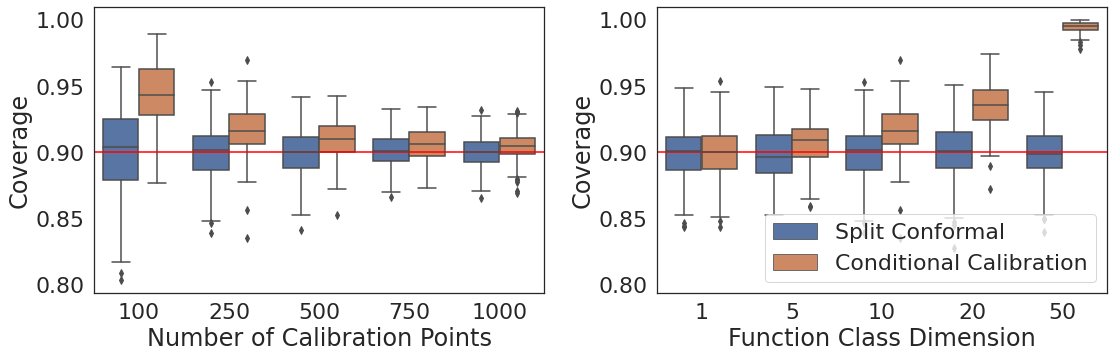

In [28]:
### Plot Results
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure()
fig.set_size_inches(16, 5.5)
hueOrder = ['Split Conformal', 'Conditional Calibration']

movingNResults = coverageDF[coverageDF['Function Class Dimension'] == 10]

ax1 = fig.add_subplot(1,2,1)
f1 = sns.boxplot(movingNResults,x='Number of Calibration Points',y='Coverage',hue='Method',
                               hue_order=hueOrder,ax=ax1)
f1.axhline(1-alpha, color='red')

plt.legend([],[], frameon=False)

movingDResults = coverageDF[coverageDF['Number of Calibration Points'] == 250]

ax2 = fig.add_subplot(1,2,2,sharey = ax1)
f2 = sns.boxplot(movingDResults,x='Function Class Dimension',y='Coverage',hue='Method',
                               hue_order=hueOrder,ax=ax2)
f2.axhline(1-alpha, color='red')

plt.legend(title='')
plt.legend(loc='lower right')

plt.tight_layout()